# Inversion Attack On Models

This notebook requires both the `mlp_model.pth` file from `mlp.ipynb` and the `clients/` model files from  `federated.ipynb`.

In [ ]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim

sys.path.insert(0, os.path.abspath('../src'))

from models import MLP, CNN
from utils import get_mnist_loader

In [8]:
class InversionAttack:
    def __init__(self, loaded_models, target_class, device):
        self.loaded_models = loaded_models
        self.target_class = target_class
        self.device = device

    def perform_multimodel_attack(self, num_iter=1000, lr=0.01, reg_param=0.01):
        # Initialize the recovered image
        recovered_image = torch.rand(1, 1, 28, 28, requires_grad=True, device=self.device)
        optimizer = optim.Adam([recovered_image], lr=lr)

        # One-hot encode target class
        target = torch.zeros(1, 10, device=self.device)
        target[0, self.target_class] = 1

        losses = []

        for i in range(num_iter):
            optimizer.zero_grad()

            classification_loss = 0
            for model in self.loaded_models:
                pred = model(recovered_image)
                classification_loss += -torch.sum(target * torch.log(pred + 1e-10))

            # Average the classification loss
            classification_loss /= len(self.loaded_models)

            # Total variation regularization
            tv_loss = torch.sum(torch.abs(recovered_image[:, :, :, :-1] - recovered_image[:, :, :, 1:])) + \
                      torch.sum(torch.abs(recovered_image[:, :, :-1, :] - recovered_image[:, :, 1:, :]))
            tv_loss = tv_loss * reg_param

            # L2 regularization
            l2_loss = torch.sum(recovered_image ** 2) * 0.001

            # Combine all losses
            total_loss = classification_loss + tv_loss + l2_loss

            # Backpropagate and update
            total_loss.backward()
            optimizer.step()

            # Clamp values to valid image range
            with torch.no_grad():
                recovered_image.clamp_(0, 1)

            # Log progress
            if i % 400 == 0:
                losses.append(classification_loss.item())
                print(f"[{i}, {classification_loss.item():.4f}]")

        # Convert final result to numpy array
        with torch.no_grad():
            recovered_image_np = recovered_image.cpu().numpy()

        options = {
            'losses': losses,
            'target_class': self.target_class,
            'device': self.device,
            'num_iter': num_iter,
            'lr': lr,
            'reg_param': reg_param
        }

        return recovered_image_np, options

    def perform_attack(self, epochs=1000, lr=0.01, reg_param=0.01):
        model = CNN().to(self.device)
        model.load_state_dict({k: v.to(self.device) for k, v in self.model_params.items()})
        model.eval()

        recovered_image = torch.rand(1, 1, 28, 28, requires_grad=True, device=self.device)

        optimizer = optim.Adam([recovered_image], lr=lr)

        target = torch.zeros(1, 10, device=self.device)
        target[0, self.target_class] = 1

        losses = []

        for i in range(epochs):
            optimizer.zero_grad()

            pred = model(recovered_image)

            classification_loss = -torch.sum(target * torch.log(pred + 1e-10))

            tv_loss = torch.sum(torch.abs(recovered_image[:, :, :, :-1] - recovered_image[:, :, :, 1:])) + \
                    torch.sum(torch.abs(recovered_image[:, :, :-1, :] - recovered_image[:, :, 1:, :]))
            tv_loss = tv_loss * reg_param

            l2_loss = torch.sum(recovered_image ** 2) * 0.001

            total_loss = classification_loss + tv_loss + l2_loss

            total_loss.backward()
            optimizer.step()

            with torch.no_grad():
                recovered_image.clamp_(0, 1)

            if i % 800 == 0:
                losses.append(classification_loss.item())
                print(f"[{i}, {classification_loss.item():.4f}]")

        with torch.no_grad():
            recovered_image_np = recovered_image.cpu().numpy()

        return recovered_image_np, losses

## Attack and Analysis

The following code block contains the creation and execution of the inversion attack class.

In [13]:
def load_models(device='cpu'):
    if not os.path.exists('../models/mlp_model.pth') or not os.path.exists('../models/clients/model-0.pth'):
        print('Missing required model files.')
        return None, None

    mlp_model = MLP()
    mlp_model.load_state_dict(torch.load('../models/mlp_model.pth'))
    mlp_model.to(device)
    mlp_model.eval()

    cnn_models = []
    index = 0

    while True:
        model_path = os.path.join('../models/clients', f'model-{index}.pth')
        if not os.path.exists(model_path):
            break

        model = CNN()
        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()

        cnn_models.append(model)
        index += 1

    return mlp_model, cnn_models

device = ('mps' if torch.mps.is_available() else 'cpu')
mlp_model, cnn_models = load_models(device)

print('Successfully loaded models!')

Successfully loaded models!


/Users/lucastheliu/Projects/research/.venv/lib/python3.13/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[0, 2.3767]


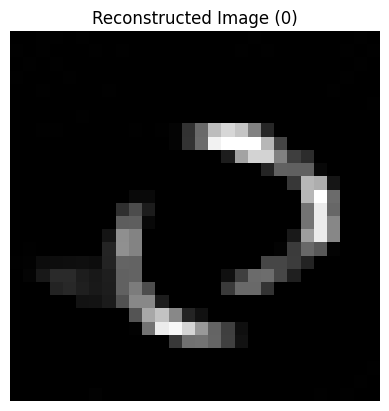

In [15]:
train_loader, test_loader = get_mnist_loader()

attack = InversionAttack(
    loaded_models=cnn_models,
    target_class=0,
    device=device
)

result, options = attack.perform_multimodel_attack(
    num_iter=400,
    lr=0.1,
    reg_param=1e-4
)

image = np.squeeze(result)
plt.imshow(image, cmap='gray')
plt.title(f'Reconstructed Image ({options['target_class']})')
plt.axis('off')
plt.show()